

# Project: TMDb Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

In this project, I'll be analyzing the dataset assocated with TMDb movies. This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue. 


### Question(s) for Analysis
  1. Which movie generated the highest and lowest Revenue?
  2. What is the average run time of all movies?



## Data Loading and importation of packages for analysis



In [42]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%  matplotlib inline




In [43]:
#Loading the data set of tmdb-movies
df =pd.read_csv('tmdb-movies.csv')
#printing the first five rows
df.head()


,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [44]:
#printing the last 10 rows of the data set
df.tail(10)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
10856,20277,tt0061135,0.140934,0,0,The Ugly Dachshund,Dean Jones|Suzanne Pleshette|Charles Ruggles|K...,NaN,Norman Tokar,A HAPPY HONEYMOON GOES TO THE DOGS!...When a G...,...,The Garrisons (Dean Jones and Suzanne Pleshett...,93,Comedy|Drama|Family,Walt Disney Pictures,2/16/66,14,5.7,1966,0.000000,0.0
10857,5921,tt0060748,0.131378,0,0,Nevada Smith,Steve McQueen|Karl Malden|Brian Keith|Arthur K...,NaN,Henry Hathaway,Some called him savage- and some called him sa...,...,Nevada Smith is the young son of an Indian mot...,128,Action|Western,Paramount Pictures|Solar Productions|Embassy P...,6/10/66,10,5.9,1966,0.000000,0.0
10858,31918,tt0060921,0.317824,0,0,"The Russians Are Coming, The Russians Are Coming",Carl Reiner|Eva Marie Saint|Alan Arkin|Brian K...,NaN,Norman Jewison,IT'S A PLOT! ...to make the world die laughing!!,...,"Without hostile intent, a Soviet sub runs agro...",126,Comedy|War,The Mirisch Corporation,5/25/66,11,5.5,1966,0.000000,0.0
10859,20620,tt0060955,0.089072,0,0,Seconds,Rock Hudson|Salome Jens|John Randolph|Will Gee...,NaN,John Frankenheimer,NaN,...,A secret organisation offers wealthy people a ...,100,Mystery|Science Fiction|Thriller|Drama,Gibraltar Productions|Joel Productions|John Fr...,10/5/66,22,6.6,1966,0.000000,0.0
10860,5060,tt0060214,0.087034,0,0,Carry On Screaming!,Kenneth Williams|Jim Dale|Harry H. Corbett|Joa...,NaN,Gerald Thomas,Carry On Screaming with the Hilarious CARRY ON...,...,The sinister Dr Watt has an evil scheme going....,87,Comedy,Peter Rogers Productions|Anglo-Amalgamated Fil...,5/20/66,13,7.0,1966,0.000000,0.0
10861,21,tt0060371,0.080598,0,0,The Endless Summer,Michael Hynson|Robert August|Lord 'Tally Ho' B...,NaN,Bruce Brown,NaN,...,"The Endless Summer, by Bruce Brown, is one of ...",95,Documentary,Bruce Brown Films,6/15/66,11,7.4,1966,0.000000,0.0
10862,20379,tt0060472,0.065543,0,0,Grand Prix,James Garner|Eva Marie Saint|Yves Montand|Tosh...,NaN,John Frankenheimer,Cinerama sweeps YOU into a drama of speed and ...,...,Grand Prix driver Pete Aron is fired by his te...,176,Action|Adventure|Drama,Cherokee Productions|Joel Productions|Douglas ...,12/21/66,20,5.7,1966,0.000000,0.0
10863,39768,tt0060161,0.065141,0,0,Beregis Avtomobilya,Innokentiy Smoktunovskiy|Oleg Efremov|Georgi Z...,NaN,Eldar Ryazanov,NaN,...,An insurance agent who moonlights as a carthie...,94,Mystery|Comedy,Mosfilm,1/1/66,11,6.5,1966,0.000000,0.0
10864,21449,tt0061177,0.064317,0,0,"What's Up, Tiger Lily?",Tatsuya Mihashi|Akiko Wakabayashi|Mie Hama|Joh...,NaN,Woody Allen,WOODY ALLEN STRIKES BACK!,...,"In comic Woody Allen's film debut, he took the...",80,Action|Comedy,Benedict Pictures Corp.,11/2/66,22,5.4,1966,0.000000,0.0
10865,22293,tt0060666,0.035919,19000,0,Manos: The Hands of Fate,Harold P. Warren|Tom Neyman|John Reynolds|Dian...,NaN,Harold P. Warren,It's Shocking! It's Beyond Your Imagination!,...,A family gets lost on the road and stumbles up...,74,Horror,Norm-Iris,11/15/66,15,1.5,1966,127642.279154,0.0


<a id='wrangling'></a>
## Data Wrangling

In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis.

## Observations from above dataset are:
The dataset has not provided the currency for columns we will be dealing with 
Even the vote count is not same for all the movies and hence this affects the vote average column.

### General Properties
Let's check the dataset and see what cleaning does it requires.

In [45]:
# number of rows and columns
df.shape

(10866, 21)

In [46]:
# To get the description of the dataset
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


In [47]:
# missing data
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [48]:
#  explore data types
df.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [50]:
# To calculate number of duplicated rows
df.duplicated().sum()

1

In [51]:
# to calculate the value counts of genres and budgets
df.groupby('genres')['budget'].value_counts()

genres                                     budget   
Action                                     0            28
                                           5000000       3
                                           10000000      2
                                           40000000      2
                                           70000000      2
                                           1500000       1
                                           5500000       1
                                           6000000       1
                                           6800000       1
                                           7000000       1
                                           7200000       1
                                           7500000       1
                                           8000000       1
                                           8256269       1
                                           15000000      1
                                           16000000      1
   


### Data Cleaning
Cleaning that needs to be prformed by looking at above data:
1. Remove columns such as 'id', 'imdb_id', 'popularity', 'budget_adj', 'revenue_adj', 'homepage', 'keywords', 'director', 'tagline', 'overview', 'production_companies', 'vote_count' and 'vote_average'.
2. Lets delete the one duplicated row that we have in our dataset.
3. There are lots of movies where the budget or revenue have a value of '0' which means that the values of those movies has not been recorded. So we need to discard this rows, since we cannot calculate profit of such movies
4. The 'release_date' column must be converted into date format.
5. Convert budget and revenue column to int datatype.
6. Replace runtime value of 0 to NAN, Since it will affect the result.

First, remove columns such as 'id', 'imdb_id', 'popularity', 'budget_adj', 'revenue_adj', 'homepage', 'keywords', 'director', 'tagline', 'overview', 'production_companies', 'vote_count' and 'vote_average'.


In [52]:
 # dropping columns
df.drop(['homepage', 'id', 'popularity', 'budget_adj', 'revenue_adj', 'vote_count', 'vote_average','keywords', 'tagline', 'cast', 'overview', 'production_companies', 'imdb_id'], axis=1, inplace=True)

In [53]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [54]:
# drop rows where revenue is zero
df.drop(df[df['revenue'] == 0].index, inplace = True)

In [55]:
# convert release date from string ro datetime
df.release_date=pd.to_datetime(df.release_date) 
df.dtypes

budget                     int64
revenue                    int64
original_title            object
director                  object
runtime                    int64
genres                    object
release_date      datetime64[ns]
release_year               int64
dtype: object

In [56]:
df['runtime'] = df['runtime'].replace(0, np.NaN)
# Check the stats of dataset
df.describe()

,budget,revenue,runtime,release_year
count,4.849000e+03,4.849000e+03,4849.000000,4849.000000
mean,2.956961e+07,8.923886e+07,107.968035,2000.919777
std,4.051761e+07,1.620801e+08,21.113779,11.569650
min,0.000000e+00,2.000000e+00,15.000000,1960.000000
25%,1.700000e+06,7.732325e+06,95.000000,1994.000000
50%,1.500000e+07,3.185308e+07,104.000000,2004.000000
75%,4.000000e+07,9.996575e+07,117.000000,2010.000000
max,4.250000e+08,2.781506e+09,705.000000,2015.000000


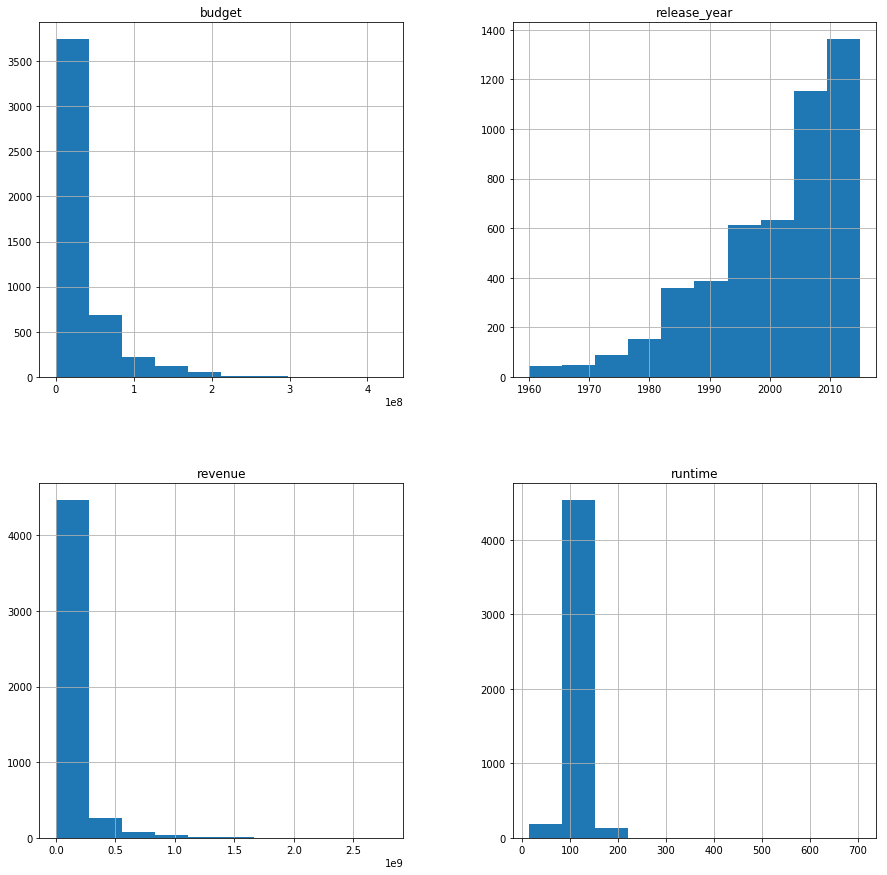

In [57]:
# To visualize columns
df.hist(figsize =(15, 15));

<a id='eda'></a>
### Exploratory Data Analysis

We will now compute statistics and create visualizations with the goal of addressing the research questions that we posed in the Introduction section.

## Question1. Which movie generated the highest and lowest Revenue?

In [58]:
# To get the average of revenue
df.revenue.mean()

89238858.70798102

In [59]:
# To get the Movie with Highest Revenue
df.loc[df['revenue'].idxmax()]

budget                                           237000000
revenue                                         2781505847
original_title                                      Avatar
director                                     James Cameron
runtime                                                162
genres            Action|Adventure|Fantasy|Science Fiction
release_date                           2009-12-10 00:00:00
release_year                                          2009
Name: 1386, dtype: object

In [60]:
# Movie with Lowest Revenue
df.loc[df['revenue'].idxmin()]

budget                        6000000
revenue                             2
original_title        Shattered Glass
director                    Billy Ray
runtime                            94
genres                  Drama|History
release_date      2003-11-14 00:00:00
release_year                     2003
Name: 5067, dtype: object

## Answer
### Movies that generated the highest and lowest revenue are
Higest - Avartar with the revenue of 2781505847
Lowest - Shatteres Glass with revenue of 2

We can check the relationship between Revenue and Profit, revenue and budget by plotting a scatter plot


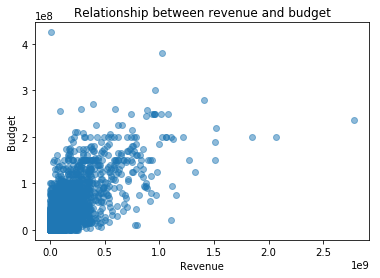

In [61]:
#Realtionship between Revenue and Budget
#To plot the scatter plot
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.title('Relationship between revenue and budget')
plt.scatter(df['revenue'], df['budget'], alpha=0.5)
plt.show()

The relationship between Revenue and Budget is not too strong

In [62]:
# first lets calculate the profit
df['profit'] = df['revenue'] - df['budget']
# Lets look at the new dataset
df.head()

,budget,revenue,original_title,director,runtime,genres,release_date,release_year,profit
0,150000000,1513528810,Jurassic World,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,2015,1363528810
1,150000000,378436354,Mad Max: Fury Road,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,2015,228436354
2,110000000,295238201,Insurgent,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2015-03-18,2015,185238201
3,200000000,2068178225,Star Wars: The Force Awakens,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,2015-12-15,2015,1868178225
4,190000000,1506249360,Furious 7,James Wan,137,Action|Crime|Thriller,2015-04-01,2015,1316249360


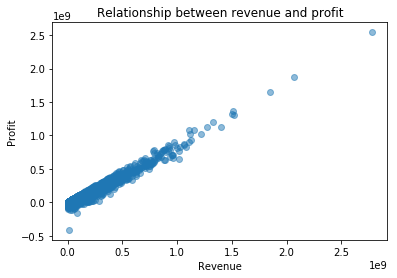

In [63]:
#To plot the scatter plot
plt.xlabel('Revenue')
plt.ylabel('Profit')
plt.title('Relationship between revenue and profit')
plt.scatter(df['revenue'], df['profit'], alpha=0.5)
plt.show()

We can see that there is a stong relationship between profit and revenue. the higher the profit, the higher revenue

### 2. What is the average run time of all movies??

In [64]:
# To get the Average runtime of movies
df['runtime'].mean()

107.96803464631883

ANSWER: The average runtime of all movies is 107.96 minutes

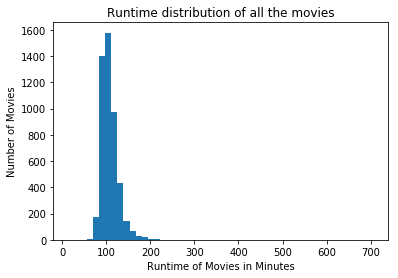

In [65]:
# Plotting a histogram to show the distribution of runtimes of all movies
plt.xlabel('Runtime of Movies in Minutes')
plt.ylabel('Number of Movies')
plt.title('Runtime distribution of all the movies')
# Plot a histogram
plt.hist(df['runtime'], bins = 50);

We can see that most of the movies are in the range of 90minutes to 130 minutes

We can also check for the successfull genres 



<a id='conclusions'></a>
## Conclusions
 1. The average movie revenue is 89238858.70
 2. There is a strong positice correlation between profit and revenue
 3. The average runtime of the movies in the dataset is around 107.96 minutes


##  Limitations of the Dataset 

The currency of the dataset was not specified and we have some incomplete rows



In [66]:
Conclusions: 
    1. The average movie revenue is 89238858.70
    2. There is a strong positice correlation between profit and revenue
    2. The average runtime of the movies in the dataset is around 107.96 minutes

SyntaxError: invalid syntax (<ipython-input-66-19560c3d84e9>, line 1)

Limitations of the Dataset
The currency of the dataset was not specified and we have some incomplete rows.

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0